In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import local_binary_pattern
import zipfile

In [38]:
# Define paths for dataset ZIP files
first_print_zip = "/content/First Print-20250324T042236Z-001.zip"
second_print_zip = "/content/Second Print-20250324T042237Z-001.zip"
extract_path = "/content/dataset"

# Create extraction directory
os.makedirs(extract_path, exist_ok=True)

# Function to extract ZIP files
def extract_zip(zip_path, target_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)

# Extract both ZIP files
extract_zip(first_print_zip, extract_path)
extract_zip(second_print_zip, extract_path)

print("Extraction completed!")


Extraction completed!


In [39]:
# Function to load images from folder and assign labels
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(label)
    return images, labels

In [40]:
# Load dataset
first_print_path = "/content/dataset/First Print"
second_print_path = "/content/dataset/Second Print"

In [41]:
first_images, first_labels = load_images_from_folder(first_print_path, 0)  # Original QR codes
second_images, second_labels = load_images_from_folder(second_print_path, 1)  # Counterfeit QR codes

In [42]:
# Combine datasets
X = np.array(first_images + second_images)
y = np.array(first_labels + second_labels)
X = X / 255.0  # Normalize pixel values
X = X.reshape(X.shape[0], 128, 128, 1)  # Reshape for CNN input

In [43]:
# Display dataset information
print("Total images:", len(X))
print("Original prints:", sum(y == 0))
print("Counterfeit prints:", sum(y == 1))

Total images: 200
Original prints: 100
Counterfeit prints: 100


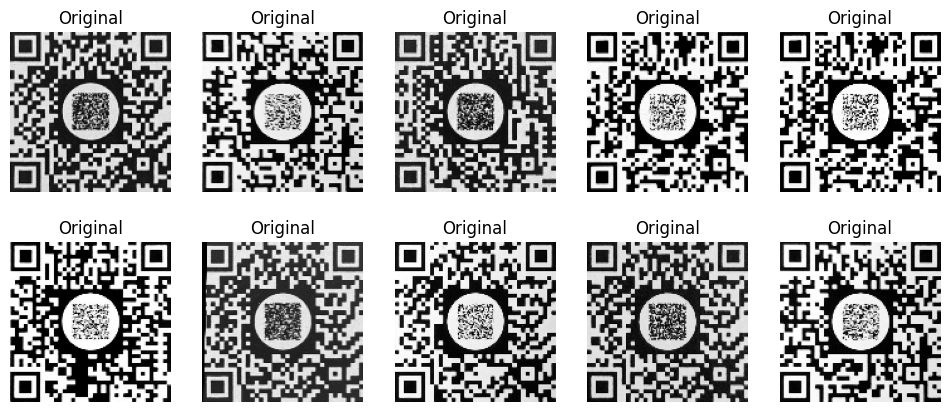

In [44]:
# Visualizing sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].squeeze(), cmap='gray')
    ax.set_title("Original" if y[i] == 0 else "Counterfeit")
    ax.axis('off')
plt.show()

In [45]:
#Data Augmentation
#Applying transformations to enhance model generalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

In [46]:
# Feature Engineering
# Edge detection using Canny
X_edges = np.array([cv2.Canny(img.squeeze().astype(np.uint8), 100, 200) for img in X])
X_edges = X_edges.reshape(X_edges.shape[0], 128, 128, 1)

In [47]:
# Extract LBP and HOG features for SVM
def extract_features(images):
    hog = cv2.HOGDescriptor()
    features = []
    for img in images:
        lbp = local_binary_pattern(img.squeeze(), P=24, R=3, method='uniform')
        hog_feat = hog.compute(img.squeeze().astype(np.uint8)).flatten()
        combined_feat = np.hstack((lbp.flatten(), hog_feat))
        features.append(combined_feat)
    return np.array(features)

In [48]:
#Extract features
X_features = extract_features(X.squeeze())
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [49]:
#Train SVM model
svm = SVC(kernel='rbf', C=10, gamma='scale')  # Improved SVM with RBF kernel
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))

SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



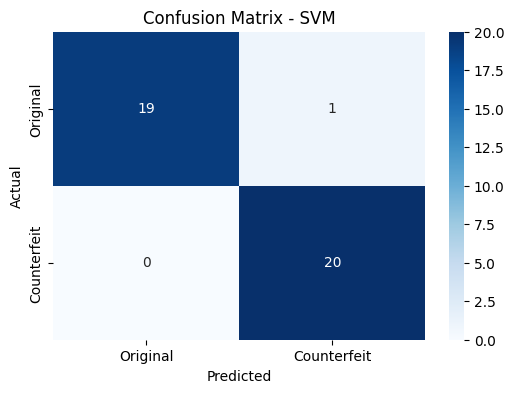

In [50]:
#Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

In [51]:
# CNN Model Definition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
#Compile CNN Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
#Train CNN Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5168 - loss: 0.7920 - val_accuracy: 0.5750 - val_loss: 0.6829
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6431 - loss: 0.6782 - val_accuracy: 0.9250 - val_loss: 0.6699
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6658 - loss: 0.6696 - val_accuracy: 0.9250 - val_loss: 0.6233
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7309 - loss: 0.6271 - val_accuracy: 0.6750 - val_loss: 0.5585
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7123 - loss: 0.5852 - val_accuracy: 0.9000 - val_loss: 0.4252
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8297 - loss: 0.4658 - val_accuracy: 0.9000 - val_loss: 0.3173
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8696 - loss: 0.3792 - val_accuracy: 0.8750 - val_loss: 0.2948
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8239 - loss: 0.3803 - val_accuracy: 0.9500 - val_loss: 0.2072

In [55]:
# CNN Model Evaluation
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("CNN Classification Report:\n", classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



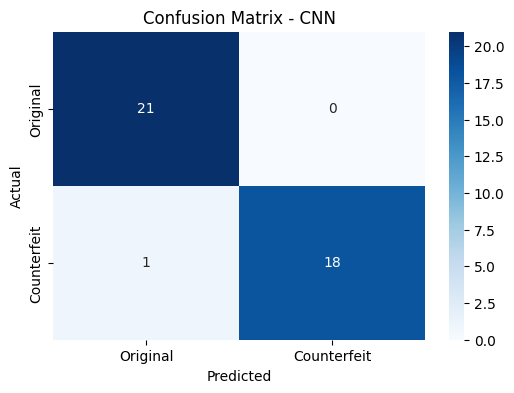

In [56]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()

In [57]:
#Save the trained model
model.save("qr_code_authentication_model.h5")